In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps

from pymle.models import BrownianMotion, CEV, CIR, CKLS, GeometricBM, IGBM, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
from pymle.fit.Minimizer import ScipyMinimizer

# 1

<AxesSubplot: xlabel='DATE'>

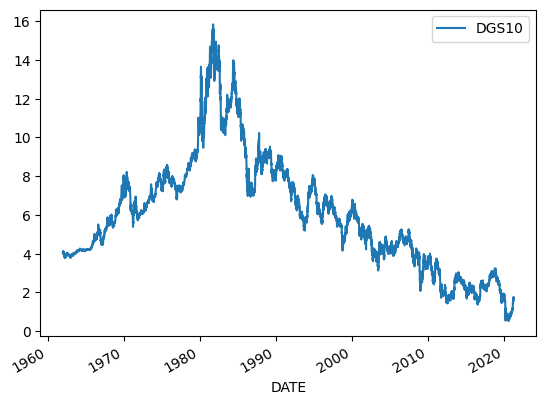

In [63]:
df = pd.read_csv('DGS10.csv', parse_dates=['DATE'], na_values='.')
df = df.dropna()

df = df[df.DATE < '2021-04-08']

df.plot(x='DATE', y='DGS10')

In [114]:
models = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.001, 2)],                         # Brownian Motion
    [(0.01, 10), (0.001, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.001, 10),(0.01, 2)],              # CIR
    [(0.01, 10), (0.001, 2)],                         # GBM
    [(0.01, 10), (0.001, 10),(0.01, 2)],              # IGBM
    [(0.01, 10), (0.001, 10),(0.01, 2)],              # OU
    [(0.25, 10), (0.001, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess  = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]

dt = 1 / 252

funcs = [KesslerDensity, ShojiOzakiDensity, EulerDensity]

In [115]:
X = df['DGS10'].values
cols = ['Model', "Benchmark", 'AIC', 'Parameters']

results = []

for j, func in enumerate(funcs):
    f_name = func.__name__
    for i, model in enumerate(models):
        m_name = model.__class__.__name__
        estimator = AnalyticalMLE(X, param_bounds[i], dt, density=func(model))
        estimator._minimizer = ScipyMinimizer(method='L-BFGS-B', options={"maxiter": 400})
        #estimator._minimizer = ScipyMinimizer(options={"maxiter": 1000})
        res = estimator.estimate_params(param_guess[i])
        aic = res.aic
        params = res.params
        result = [m_name, f_name, np.round(aic, decimals=3), np.round(params, decimals=3)]
        results.append(result)
        
df_summary = pd.DataFrame(results, columns=cols)

In [116]:
df_summary.sort_values(by='AIC', ascending=True)

,Model,Benchmark,AIC,Parameters
20,CKLS,EulerDensity,-40508.985,"[0.25, 0.001, 0.601, 0.302]"
15,CEV,EulerDensity,-40446.759,"[0.01, 10.0, 0.637, 0.283]"
2,CIR,KesslerDensity,-40076.353,"[0.01, 0.255, 0.442]"
16,CIR,EulerDensity,-40070.151,"[0.01, 0.079, 0.443]"
9,CIR,ShojiOzakiDensity,-40070.149,"[0.01, 0.058, 0.443]"
14,BrownianMotion,EulerDensity,-38860.449,"[0.01, 1.03]"
7,BrownianMotion,ShojiOzakiDensity,-38860.449,"[0.01, 1.03]"
12,OrnsteinUhlenbeck,ShojiOzakiDensity,-38859.014,"[0.013, 0.082, 1.03]"
19,OrnsteinUhlenbeck,EulerDensity,-38858.996,"[0.011, 0.139, 1.03]"
5,OrnsteinUhlenbeck,KesslerDensity,-38858.845,"[0.01, 10.0, 1.031]"


<AxesSubplot: xlabel='DATE'>

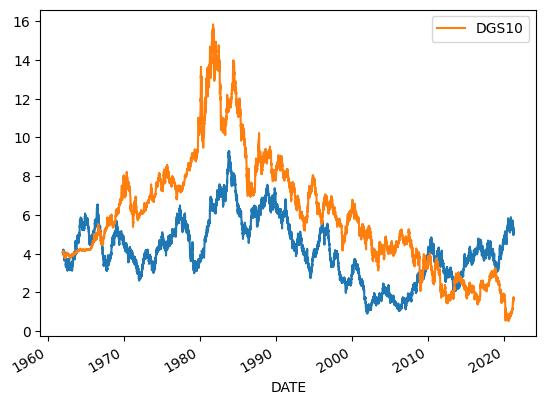

In [112]:
best = CKLS()
best.params = [0.25, 0.001, 0.577, 0.323]

sim = Simulator1D(df['DGS10'].values[0], df.shape[0] - 1, 1/252, best, method='Euler')
sample = np.loadtxt('DGS10.txt')

fig, ax = plt.subplots()
ax.plot(df['DATE'], sample)
df.plot('DATE', 'DGS10', ax=ax)

# 2

<AxesSubplot: xlabel='DATE'>

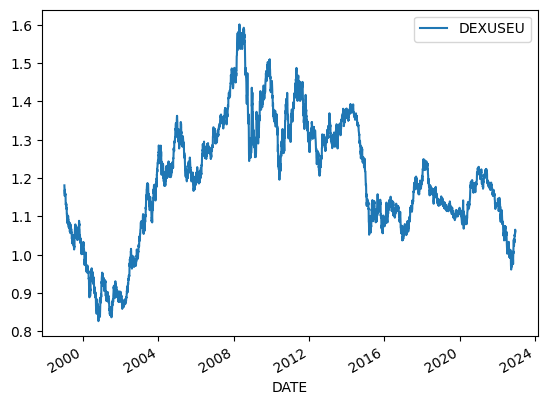

In [117]:
df = pd.read_csv('DEXUSEU.csv', parse_dates=['DATE'], na_values='.')
df = df.dropna()
df.plot(x='DATE', y='DEXUSEU')

In [120]:
X = df['DEXUSEU'].values
cols = ['Model', "Benchmark", 'AIC', 'Parameters']

results = []

for j, func in enumerate(funcs):
    f_name = func.__name__
    for i, model in enumerate(models):
        m_name = model.__class__.__name__
        estimator = AnalyticalMLE(X, param_bounds[i], dt, density=func(model))
        #estimator._minimizer = ScipyMinimizer(method='L-BFGS-B')
        res = estimator.estimate_params(param_guess[i])
        aic = res.aic
        params = res.params
        result = [m_name, f_name, np.round(aic, decimals=3), np.round(params, decimals=3)]
        results.append(result)
        
df_summary = pd.DataFrame(results, columns=cols)
df_summary.sort_values(by='AIC').head()

/home/vladislav/.cache/pypoetry/virtualenvs/stochastic-prac-uipVSqoA-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 114, CG iterations: 60, optimality: 2.25e-04, constraint violation: 0.00e+00, execution time: 0.16 s.
`xtol` termination condition is satisfied.
Number of iterations: 228, function evaluations: 1210, CG iterations: 737, optimality: 1.24e-01, constraint violation: 0.00e+00, execution time:  1.8 s.
`xtol` termination condition is satisfied.
Number of iterations: 79, function evaluations: 296, CG iterations: 139, optimality: 1.54e-01, constraint violation: 0.00e+00, execution time:  0.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 127, function evaluations: 393, CG iterations: 231, optimality: 2.97e-03, constraint violation: 0.00e+00, execution time: 0.48 s.
`xtol` termination condition is satisfied.
Number of iterations: 108, function evaluations: 440, CG iterations: 218, optimality: 6.53e-02, constraint violation: 0.00e+00, execution time: 0.41 s.
`xtol` termination conditio

,Model,Benchmark,AIC,Parameters
4,IGBM,KesslerDensity,-42554.664,"[0.219, 1.172, 0.094]"
18,IGBM,EulerDensity,-42554.648,"[0.215, 1.171, 0.094]"
11,IGBM,ShojiOzakiDensity,-42554.648,"[0.215, 1.171, 0.094]"
10,GeometricBM,ShojiOzakiDensity,-42553.924,"[0.01, 0.094]"
17,GeometricBM,EulerDensity,-42553.924,"[0.01, 0.094]"


<AxesSubplot: xlabel='DATE'>

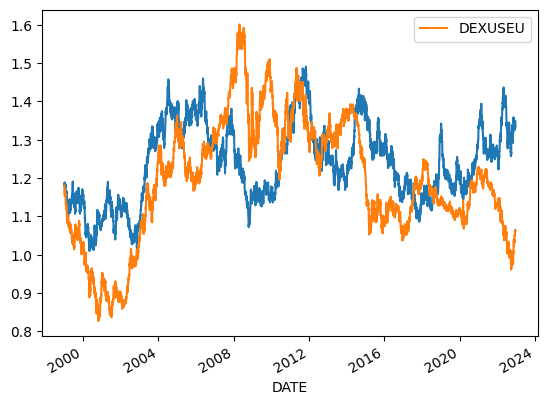

In [121]:
best = IGBM()
best.params = [0.219, 1.172, 0.094]

sim = Simulator1D(df['DEXUSEU'].values[0], df.shape[0] - 1, dt, best, method='Euler')
sample = sim.sim_path()

fig, ax = plt.subplots()
ax.plot(df['DATE'], sample)
df.plot('DATE', 'DEXUSEU', ax=ax)

<AxesSubplot: xlabel='DATE'>

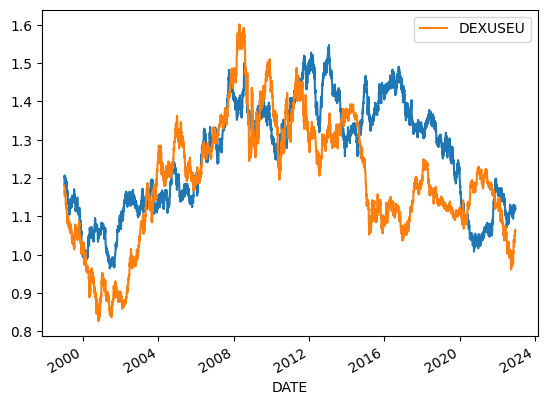

In [129]:

best = IGBM()
best.params = [0.219, 1.172, 0.094]

sim = Simulator1D(df['DEXUSEU'].values[0], df.shape[0] - 1, 1/365, best, method='Euler')
sample = sim.sim_path()

fig, ax = plt.subplots()
ax.plot(df['DATE'], sample)
df.plot('DATE', 'DEXUSEU', ax=ax)